# Open Loop Microstep and Current Control

The purpose of this notebook is to develop the relationship between microstepping and current control in a stepper motor driver for open loop control.

There are several ways to integrate current control and microsteps in circuitry by using current sense resistors. The end result of these types of circuits is a [chopper drive](https://en.wikipedia.org/wiki/Chopper_(electronics)) where the motor coils are on and off rapidly to limit the voltage, thereby regulating the current. However, current sensing is inherently a closed loop system with more complexity than an open loop system. The hope is that by developing a _coupled_  current and microstep system some complexity of the current sensed case may be reduced.  

In [1]:
using Plots

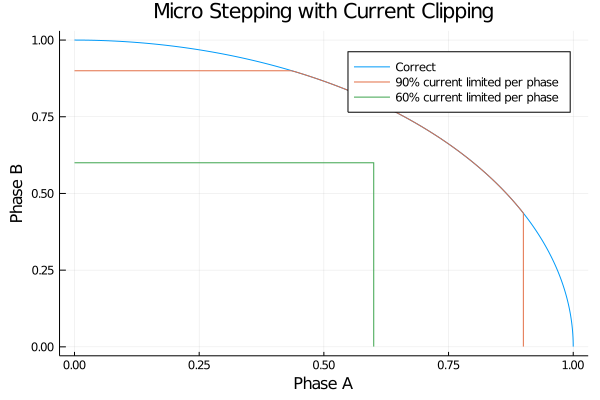

In [2]:
rng = 0:0.01:pi/2
plot(sin.(rng), cos.(rng), xlabel="Phase A", ylabel="Phase B", title="Micro Stepping with Current Clipping", label="Correct")
plot!(clamp.(sin.(rng), 0, 0.9), clamp.(cos.(rng), 0, 0.9), label="90% current limited per phase")
plot!(clamp.(sin.(rng), 0, 0.6), clamp.(cos.(rng), 0, 0.6), label="60% current limited per phase")

In the above we see that current limiting both in chopper drive and open loop can have undesireable effects if microstepping is not taken into account. Here the current is limited as 90% and 60%. By simply limiting the current in a single phase the microstepping ouput (sine in Phase A, cosine in Phase B) is clipped into a square structure. Below is the idealized output taking current limits and microsteps into account.

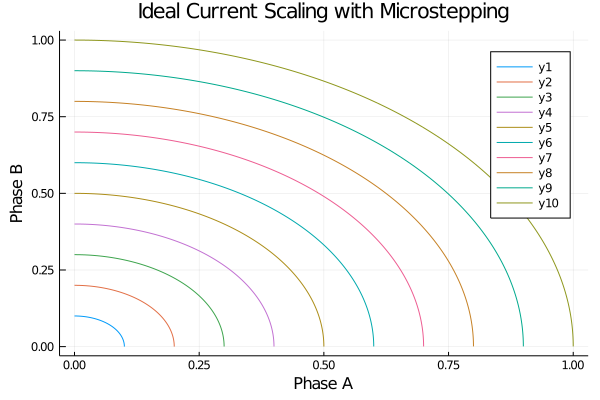

In [3]:
p = plot(xlabel="Phase A", ylabel="Phase B", title="Ideal Current Scaling with Microstepping")
for scale in .1:.1:1
    plot!(p, sin.(rng).*scale, cos.(rng).*scale, xlabel="Phase A", ylabel="Phase B")
end
display(p)

## PWM Frequency/Resolution

Here we will compare a matrix of internal clock frequencies and resolution and the output frequency. The goal is to interlace both current and microsteps into a single PWM output. Note the target is to be super audible (>24khz).

In [4]:
pll_freqs = [100e6, 150e6, 200e6, 300e6] # frequencies
bit_ct = [2^10, 2^12, 2^14, 2^16] # PWM Resolutions
pll_freqs'./bit_ct

4×4 Array{Float64,2}:
 97656.2       1.46484e5      1.95312e5      2.92969e5
 24414.1   36621.1        48828.1        73242.2
  6103.52   9155.27       12207.0        18310.5
  1525.88   2288.82        3051.76        4577.64

We see in the last two rows (14 and 16 bits respecitivly), no values are above the audible range for any given clock frequencies. 12 bit (row 2) seems ideal for frequencies 100-200Mhz. At 200Mhz we could use 13 bit PWM for additional resolution.

## Combining and Interlacing PWM

Given 12 bits of PWM Resolution we can start our exploration by using 8 bits for microstep resolution and 4 bits for current limit. 

The first potentially obvious solution is to take the microstep value and repeat based on the current limit. 

In [5]:
function pwm_repeat(nbits, nbitsms, nbitscurrent, msvalue, currentvalue)
    trng = 1:2^nbits # total PWM Range
    mrng = 1:2^nbitsms # microstep range
    crng = 1:2^nbitscurrent # current Range
    arr = resize!(repeat(map(x -> x < msvalue, mrng), currentvalue), 2^nbits)
    arr[(2^nbitsms*currentvalue):end] .= 0
    arr
end

pwm_repeat (generic function with 1 method)

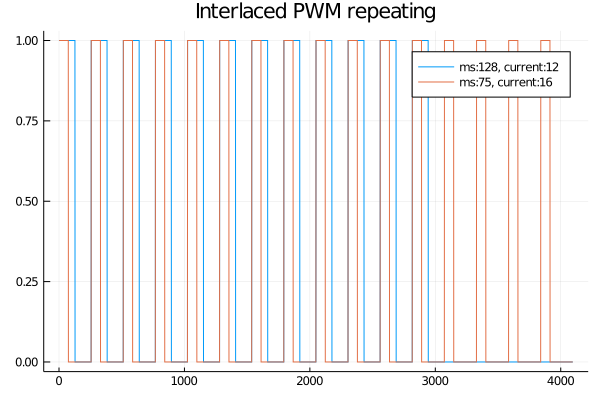

In [6]:
rng = 1:2^12
plot(rng, pwm_repeat(12, 8, 4, 128, 12), label = "ms:128, current:12", title="Interlaced PWM repeating")
plot!(rng, pwm_repeat(12, 8, 4, 75, 16), label = "ms:75, current:16")

However while this approach is simple, it is clear it does not result in the frequency we expect. In actuality the true PWM frequency is: $\frac{freq}{2^8}$ or 390Khz at a 100Mhz clock. Such high frequencies may badly affect the power circuitry so this is a point for further discussion and experimentation. 

An alternative approach respecting the carrier frequency is presented below:

In [7]:
function pwm_combined(nbits, nbitsms, nbitscurrent, msvalue, currentvalue)
    trng = 1:2^nbits # total PWM Range
    mrng = 1:2^nbitsms # microstep range
    crng = 1:2^nbitscurrent # current Range
    map(x -> x < msvalue*currentvalue, trng)
end

pwm_combined (generic function with 1 method)

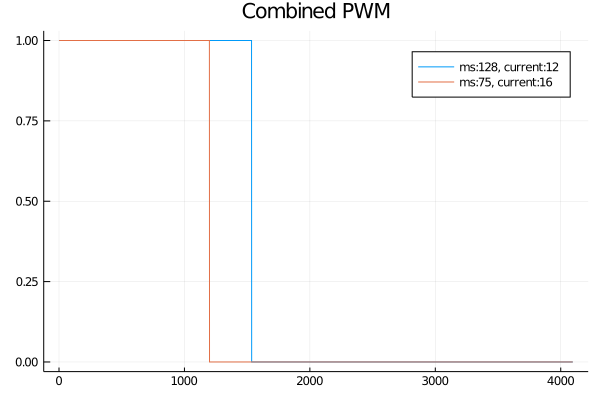

In [8]:
rng = 1:2^12
plot(rng, pwm_combined(12, 8, 4, 128, 12), label = "ms:128, current:12", title="Combined PWM")
plot!(rng, pwm_combined(12, 8, 4, 75, 16), label = "ms:75, current:16")

In the above we see a single waveform combining both current and microstep data is generated.


## Conclusion

We have demonstrated two ways to combine microstep and current limit values in an open loop system. Similarly, the basic frequency and resolution tradeoffs were considered. 